# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3
# Luckyanchuk Bogdan BSE-213

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [49]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC



sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w, w_0) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

##### Put your markdown formulas here

$$\nabla L(w, w_0) = \frac{\partial}{\partial w_j}(\sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})}) + \gamma \text{sign}{(w)} + 2\beta (w)$$
$$\sum_{i=1}^{N} -(\frac{y_i}{\sigma{(w^\top x_i)}} -\frac{1-y_i}{1-\sigma{(w^\top x_i)}})\frac{\partial}{\partial w_j}\sigma{(w^\top x_i)} =\sum_{i=1}^{N} -(\frac{y_i}{\sigma{(w^\top x_i)}} -\frac{1-y_i}{1-\sigma{(w^\top x_i)}})\sigma{(w^\top x_i)}(1-\sigma{(w^\top x_i)})x_{ij} = \sum_{i=1}^{N}- (y_i -\sigma{(w^\top x_i)})x_{ij}$$
$$\ \frac{\partial}{\partial w_j} L(w, w_0) = \sum_{i=1}^{N}- (y_i -\sigma{(w^\top x_i)})x_{ij} + \gamma \text{sign}{(w_j)} + 2\beta (w_j)$$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [50]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [51]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    return np.dot(-y, np.log(sigmoid(np.dot(X, w))))+np.dot(-(1-y), np.log((1-sigmoid(np.dot(X, w))))) + gamma*np.linalg.norm(w, ord=1) + beta*np.linalg.norm(w)

#### 3. [0.25 points] Implement the gradient (as a function)

In [52]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w = (np.dot(X.T, -y+sigmoid(np.dot(X, w)))) + \
        gamma*np.sign(w) + 2*beta*(w)
    return grad_w

#### Check yourself

In [53]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)
grad_w = get_grad(X, y, w)
assert (np.allclose(grad_w,
                    [-3.99447493, -1.84786723,  0.64520104,
                     1.67059973, -5.03858487, -5.21496336],
                    rtol=1e-2)
        )

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [54]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [55]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-4, tolerance=1e-5, max_iter=100000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.w = None
        self.loss_history = None
        self.w0 = None
        self.indicator_ones = False

        # you may additional properties if you wish

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.loss_history = []

        if self.indicator_ones == False:
            self.indicator_ones == True
            ones_column = np.ones((X.shape[0], 1))
            X = np.c_[ones_column, X]

        if self.w0 is None:
            self.w0 = np.random.normal(0, 1, size=X.shape[1])
            self.w = self.w0.copy()

        for i in range(self.max_iter):
            new_w = get_grad(X, y, self.w, self.gamma, self.beta)
            new_w = self.w - self.learning_rate*new_w
            diff = self.w - new_w
            if np.linalg.norm(diff, ord=1) < self.tolerance:
                break
            self.w = new_w
            self.loss_history.append(loss(X, y, self.w, self.gamma, self.beta))
        return self

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        ones_column = np.ones((X.shape[0], 1))
        X_new = np.c_[ones_column, X]
        predict = np.round(sigmoid(np.dot(X_new, self.w)))
        return predict

    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),
                         1 / (1 + np.exp(-np.dot(X, self.w)))])

In [56]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

In [57]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)

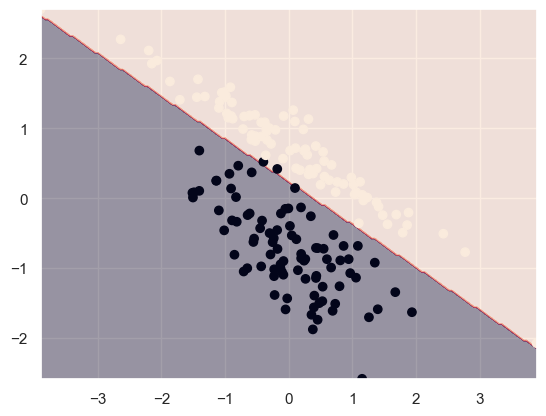

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = Logit(0, 0)
model.fit(X_scaled, y)
plot_decision_boundary(model, X_scaled, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

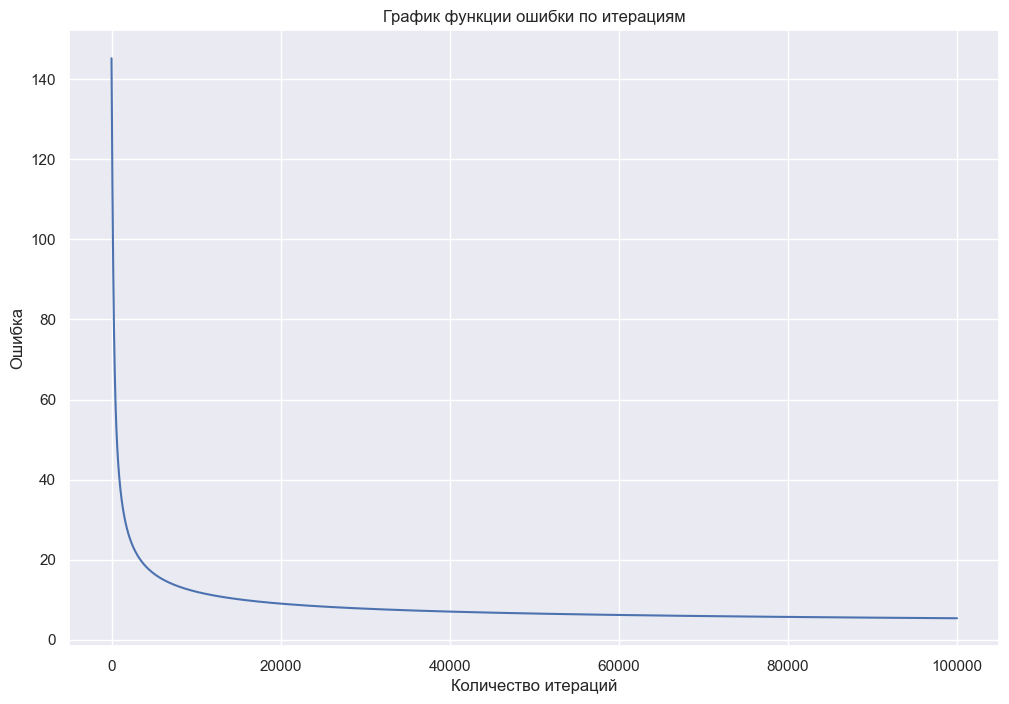

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(model.loss_history)

plt.xlabel('Количество итераций')
plt.ylabel('Ошибка')
plt.title('График функции ошибки по итерациям')

plt.show()

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

Разбиваем данные на тренировочную и тестовую выборки и скейлим их.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Зададим параметры для моделей


In [61]:
reg_coef = np.logspace(-2, -1, 50)
gamma_coef = np.logspace(-3, -1, 50)
degree_coef = list(range(2, 13))
coef_coef = np.linspace(-100,100,50)

Реализуем функцию для вывода граифков результатов

In [72]:
def show_result(poly_param:[],poly_result:dict, param_name):
    plt.figure()
    for key, value in poly_result.items():
        plt.plot(poly_param, value, label=key, lw=2)
    plt.xlabel('Значения метрик')
    plt.ylabel('Значение параметра ' + param_name)
    plt.legend()
    plt.show()

### Исследуем Linear kernel

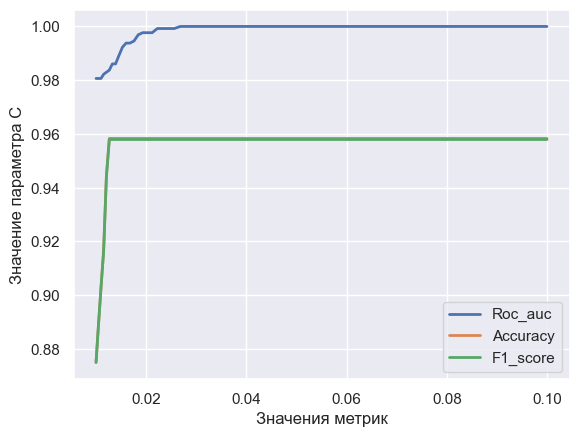

In [73]:
lin_result = {'Roc_auc': [], 'Accuracy': [], 'F1_score': []}

for coef in reg_coef:
    clf = SVC(verbose=False, probability=True, kernel='linear', C=coef)
    clf.fit(X_train_scaled, y_train)
    pred = clf.predict(X_test_scaled)
    proba = clf.predict_proba(X_test_scaled)
    lin_result['Accuracy'].append(accuracy_score(y_test, pred))
    lin_result['F1_score'].append(f1_score(y_test, pred, average='macro'))
    lin_result['Roc_auc'].append(roc_auc_score(y_test, proba[:, 1]))
show_result(reg_coef, lin_result, 'C')


На графике 

### Исследуем Poly kernel

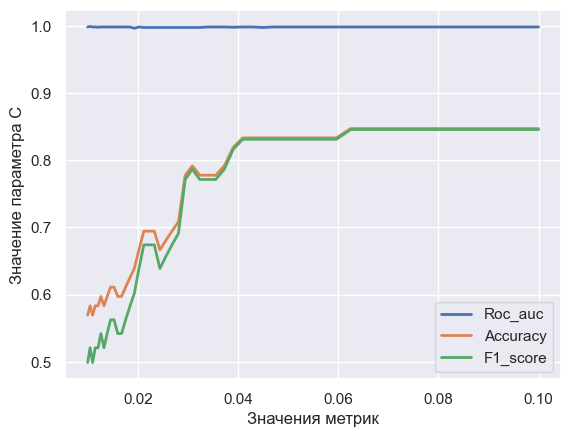

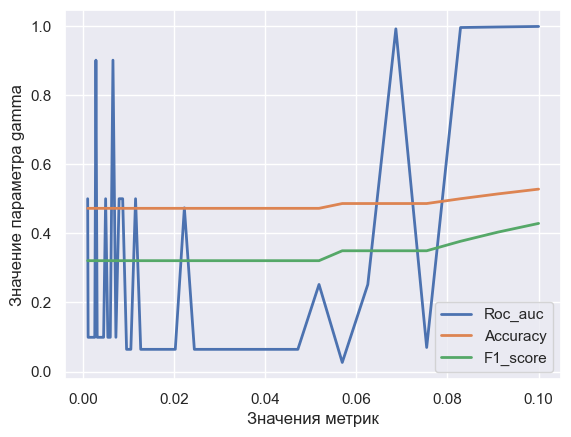

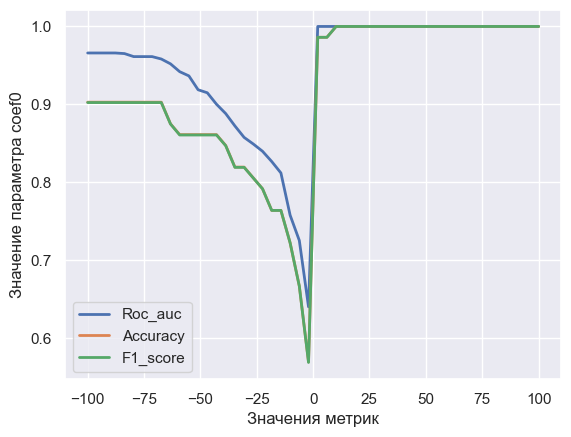

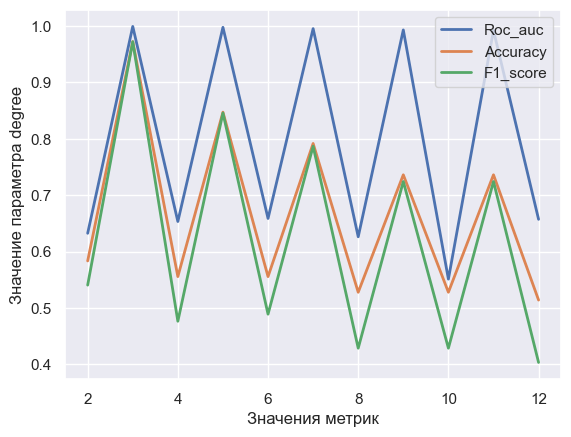

In [74]:
poly_param = {'C':reg_coef, 'gamma':gamma_coef, 'coef0':coef_coef, 'degree':degree_coef}

for param_name,param_coef in poly_param.items():
    poly_result = {'Roc_auc': [], 'Accuracy': [], 'F1_score': []}
    for coef in param_coef:
        clf = SVC(verbose=False, probability=True, kernel='poly',**{param_name:coef})
        clf.fit(X_train_scaled, y_train)
        pred = clf.predict(X_test_scaled)
        proba = clf.predict_proba(X_test_scaled)
        poly_result['Accuracy'].append(accuracy_score(y_test, pred))
        poly_result['F1_score'].append(f1_score(y_test, pred, average='macro'))
        poly_result['Roc_auc'].append(roc_auc_score(y_test, proba[:, 1]))
    show_result(param_coef, poly_result, param_name)


### Исследуем RBF kernel

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [66]:
# your code here

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [67]:
# your code here

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [68]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

*It is possible to use sklearn model instead of your own one but with a penalty of 0.5*

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute relevant metrics for test sample (use sklearn)

In [69]:
# your code here